## Udacity Data Analyst Nanodegree
### P2 - Investigate a Dataset - Baseball Data
#### Author: Jack Bae
#### Date: July 22, 2017

## Introduction

At the time of this writing, the two most valuable hitters measured in Wins Above Replacement (WAR) in Major League Baseball (MLB) among position players are Aaron Judge and Jose Altuve. Wins Above Replacement is a comprehensive statistic that measures batting, base running, and fielding into one statistic in trying to measure and compare value among players. [Fangraphs](http://www.fangraphs.com/library/misc/war/) explains WAR and its formula in detail.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Import WAR leaders from Fangraphs
fangraphs_df = pd.read_csv('/Users/jackbae/Google Drive/Udacity/P2/FanGraphs Leaderboard.csv')
fangraphs_df[['Name','WAR','AVG','HR','BB%','K%']].head(5)

,Name,WAR,AVG,HR,BB%,K%
0,Aaron Judge,5.5,0.313,32,16.8 %,30.0 %
1,Jose Altuve,4.9,0.352,14,9.3 %,12.2 %
2,Anthony Rendon,4.9,0.314,20,14.8 %,13.7 %
3,Bryce Harper,4.8,0.338,25,15.8 %,18.8 %
4,Mookie Betts,4.6,0.280,17,10.5 %,8.9 %


The stark difference between the two most valuable batters is their height difference. [Aaron Judge](http://www.fangraphs.com/statss.aspx?playerid=15640&position=OF) is 6-7 while [Jose Altuve](http://www.fangraphs.com/statss.aspx?playerid=5417&position=2B) is 5-6. 

<img src="http://www.mlb.com/assets/images/6/6/8/240077668/cuts/original_u1uc9efq_n2r3henc.jpg" style="width:30%;height:30%">

The difference in height is notable because the batter's stike zone differs by height of the batter. In [Major League Baseball 2017 Official Rules](http://mlb.mlb.com/documents/0/4/0/224919040/2017_Official_Baseball_Rules_dbt69t59.pdf), MLB defines the strike zone as follows:
> The STRIKE ZONE is that area over home plate the upper limit of
which is a horizontal line at the midpoint between the top of the shoulders
and the top of the uniform pants, and the lower level is a line at the
hollow beneath the kneecap. The Strike Zone shall be determined from
the batter’s stance as the batter is prepared to swing at a pitched ball.

Based on MLB's rule, it is evident that Aaron Judge and Jose Altuve play under different strike zones while batting. So how does the difference in stike zone translate into hitting performance? Are taller players in advantage or disadvantage when hitting?

## Qustions for Investigation
In investigating the correlation between batter's height and hitting performance, the hitter's batting average, strikeout rate, and home run rate will be used to investigate hitter's performance.

1. Is there a correlation between hitter's height and batting average?
2. Is there a correlation between hitter's height and strikeout rate?
3. Is there a correlation between hitter's height and walk rate?
4. Is there a correlation between hitter's height and home run rate?

The 2016 version of [Lahman's Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/) will be used for analysis. Specifically, the master (player names, DOB, and biographical info) and batting (batting statistics) tables will be used in the analysis.

## Data Wrangling
The data first nees to be extracted from csv file into DataFrames.

In [2]:
# Extract relevant csv files into DataFrames 
master_df = pd.read_csv('/Users/jackbae/Google Drive/Udacity/P2/baseballdatabank-2017.1/core/Master.csv')
batting_df = pd.read_csv('/Users/jackbae/Google Drive/Udacity/P2/baseballdatabank-2017.1/core/Batting.csv')
appearances_df = pd.read_csv('/Users/jackbae/Google Drive/Udacity/P2/baseballdatabank-2017.1/core/Appearances.csv')

# Display batting table with ascending year value
batting_df.sort_values('yearID',ascending=True).head(5)    

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,...,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,...,0.0,0.0,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN
84,pikeli01,1871,1,TRO,NaN,28,130,43,49,10,...,39.0,3.0,2.0,5,7.0,NaN,NaN,NaN,NaN,NaN
83,phelpne01,1871,1,FW1,NaN,1,3,0,0,0,...,0.0,0.0,0.0,1,0.0,NaN,NaN,NaN,NaN,NaN
82,pearcdi01,1871,1,NY2,NaN,33,163,31,44,5,...,20.0,0.0,0.0,4,1.0,NaN,NaN,NaN,NaN,NaN
81,patteda01,1871,1,NY2,NaN,32,151,31,31,2,...,13.0,2.0,1.0,1,0.0,NaN,NaN,NaN,NaN,NaN


The above data shows that Lahman's batting table starts data from 1871. The data needs to be limited to modern baseball era, where the current strike zone rules were implemented. Per [Baseball Almanac](http://www.baseball-almanac.com/rulechng.shtml), the current picher's mound rules and strike zone rules were implemented in 1969.

In [3]:
# Filter batting stats from 1969 forward
batting_filtered = batting_df.loc[batting_df['yearID'] >= 1969]

# Group by playerID to show batters' total career statistics
batting_filtered = batting_filtered.groupby('playerID')['G','AB','H','SO','BB','HR'].sum()

# Show hitters with more than 502 at-bats. This filters out hitters less than one full season of at-bats
batting_filtered = batting_filtered.loc[batting_filtered['AB']>= 502]

# Extract needed columns from master DataFrame
master_df_filtered = master_df[['playerID','nameFirst','nameLast','height']]

# Join filtered batting DataFrame and master Dataframe to show players height
batting_filtered = master_df_filtered.join(batting_filtered,on='playerID',how='inner')

# Group hitters by height
batting_filtered = batting_filtered.groupby('height')['G','AB','H','SO','BB','HR'].sum()

# Calculate batting average by dividing total hits by at-bats
total_ab_by_height = batting_filtered.groupby('height')['AB'].sum()
total_hits_by_height = batting_filtered.groupby('height')['H'].sum()
height_group_avg = total_hits_by_height / total_ab_by_height
batting_filtered['AVG'] = height_group_avg

# Calculate strikeout rate by dividing total strikeouts by at-bats
total_so_by_height = batting_filtered.groupby('height')['SO'].sum()
height_group_so = total_so_by_height / total_ab_by_height
batting_filtered['SO/AB'] = height_group_so

# Calculate walk rate by dividing total strikeouts by at-bats
total_bb_by_height = batting_filtered.groupby('height')['BB'].sum()
height_group_bb = total_bb_by_height / total_ab_by_height
batting_filtered['BB/AB'] = height_group_bb

# Calculate total home run rate by dividing total home runs by at-bats
total_hits_by_height = batting_filtered.groupby('height')['HR'].sum()
height_group_hr = total_hits_by_height / total_ab_by_height
batting_filtered['HR/AB'] = height_group_hr

batting_filtered

,G,AB,H,SO,BB,HR,AVG,SO/AB,BB/AB,HR/AB
height,,,,,,,,,,
65.0,1589,5322,1287,750.0,511,39,0.241826,0.140924,0.096017,0.007328
66.0,5599,16596,4411,1942.0,1072,153,0.265787,0.117016,0.064594,0.009219
67.0,10228,33400,9041,4280.0,4191,658,0.270689,0.128144,0.125479,0.019701
68.0,24757,81244,22321,11352.0,7982,1230,0.274740,0.139727,0.098247,0.015140
69.0,94906,299894,79349,39594.0,26824,4396,0.264590,0.132027,0.089445,0.014659
70.0,187194,574798,151060,86095.0,54982,10978,0.262805,0.149783,0.095654,0.019099
71.0,286200,908755,242360,134732.0,84213,18736,0.266695,0.148260,0.092669,0.020617
72.0,400181,1267145,336856,205222.0,123006,32151,0.265839,0.161956,0.097073,0.025373
73.0,358668,1133018,298001,203193.0,109194,33812,0.263015,0.179338,0.096374,0.029842


Exploring the DataFrame, we see that players with height of 82 inches has 619 games played, yet only has 625 at bats. One explanation could be this height mostly contains pitchers.

In [4]:
# Filter master DataFrame to get players height of 82 inches
height_filtered = master_df.loc[master_df['height']== 82]

# Group by player to gain total career appearances at each position
appearances_filtered = appearances_df.groupby('playerID')['G_p','G_c','G_1b','G_2b','G_3b','G_ss','G_lf','G_cf','G_rf'].sum()

# Rename position
appearances_filtered = appearances_filtered.rename(columns={'G_p':'P','G_c':'C','G_1b':'1B','G_2b':'2B','G_3b':'3B','G_ss':'SS','G_lf':'LF','G_cf':'CF','G_rf':'RF'})

# For each row, show position in which the player made most appearances in his career
appearances_filtered['Position'] = appearances_filtered.idxmax(axis=1)

# Join filtered master DataFrame and filtered appearances DataFrame to retrieve players height and position
appearance_height_join = height_filtered.join(appearances_filtered,on='playerID',how='inner')
appearance_height_join[['playerID','nameFirst','nameLast','height','Position']]

,playerID,nameFirst,nameLast,height,Position
1731,brackan01,Andrew,Brackman,82.0,P
7718,hillmer01,Eric,Hillman,82.0,P
8589,johnsra05,Randy,Johnson,82.0,P
15916,siscoan01,Andy,Sisco,82.0,P
18967,youngch03,Chris,Young,82.0,P


This table confirms that players of 82 inches who played in MLB are all pitchers. Since pitchers overall has significantly less hitting abilities, row of 82 inches could be removed for consistency of data.

In [5]:
# Drop the last row to filter out statistics from players height of 82 inches
batting_filtered = batting_filtered.drop(batting_filtered.index[len(batting_filtered)-1])
batting_filtered

,G,AB,H,SO,BB,HR,AVG,SO/AB,BB/AB,HR/AB
height,,,,,,,,,,
65.0,1589,5322,1287,750.0,511,39,0.241826,0.140924,0.096017,0.007328
66.0,5599,16596,4411,1942.0,1072,153,0.265787,0.117016,0.064594,0.009219
67.0,10228,33400,9041,4280.0,4191,658,0.270689,0.128144,0.125479,0.019701
68.0,24757,81244,22321,11352.0,7982,1230,0.274740,0.139727,0.098247,0.015140
69.0,94906,299894,79349,39594.0,26824,4396,0.264590,0.132027,0.089445,0.014659
70.0,187194,574798,151060,86095.0,54982,10978,0.262805,0.149783,0.095654,0.019099
71.0,286200,908755,242360,134732.0,84213,18736,0.266695,0.148260,0.092669,0.020617
72.0,400181,1267145,336856,205222.0,123006,32151,0.265839,0.161956,0.097073,0.025373
73.0,358668,1133018,298001,203193.0,109194,33812,0.263015,0.179338,0.096374,0.029842


## Analysis

Standard deviation: 0.00977832773903
Pearson's R: -0.311167612948


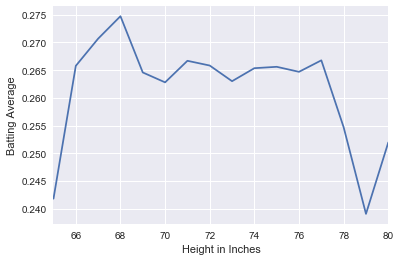

In [6]:
# Function to calculate Pearson's correlation coefficient for a sample
def pearson_r(x,y):
    return ((x-x.mean())*(y-y.mean())).mean() / (x.std(ddof=0) * y.std(ddof=0))

# Calculate batting average without height of 82
total_ab_by_height = batting_filtered.groupby('height')['AB'].sum()
total_hits_by_height = batting_filtered.groupby('height')['H'].sum()
height_group_avg = total_hits_by_height / total_ab_by_height

# Retreive height and batting average values
height_sample = batting_filtered.index.values
avg_sample = batting_filtered['AVG']

# Print standard deviation between height and batting average
print ("Standard deviation: " + str(height_group_avg.values.std(ddof=1)))

# Print Pearson's correlation coefficient for a sample
print("Pearson's R: " + str(pearson_r(height_sample,avg_sample)))

# Plot height vs batting average
fig = height_group_avg.plot()
fig.set_xlabel('Height in Inches')
fig.set_ylabel('Batting Average')

The analysis of the correlation of height and batting average shows the shortest and tallest players does not perform as well as players of average height. The Pearson's R tells there is a slight negative correlation between height and batting average. 

Standard deviation: 0.0510159591867
Pearson's R: 0.952483693319


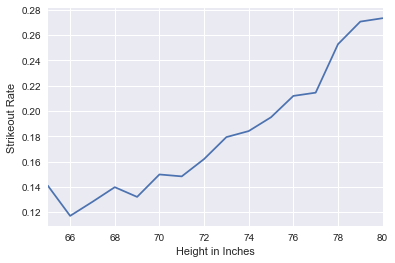

In [7]:
# Calculate strikeout rate without height of 82
total_so_by_height = batting_filtered.groupby('height')['SO'].sum()
height_group_so = total_so_by_height / total_ab_by_height

# Retrieve strikeout value
so_sample = batting_filtered['SO/AB']

# Print standard deviation between height and strikeout rate
print ("Standard deviation: " + str(height_group_so.values.std(ddof=1)))

# Print Pearson's correlation coefficient for a sample
print("Pearson's R: " + str(pearson_r(height_sample,so_sample)))

# Plot height vs strikeout rate
fig = height_group_so.plot()
fig.set_xlabel('Height in Inches')
fig.set_ylabel('Strikeout Rate')

The analysis of the correlation of height and strikeout rate average shows the taller players are prone to more stikeouts. The Pearson's R value confirms this, as the value of 0.95 shows strong correlation between height and strikeout rate. 

Standard deviation: 0.0142575653397
Pearson's R: 0.50322326506


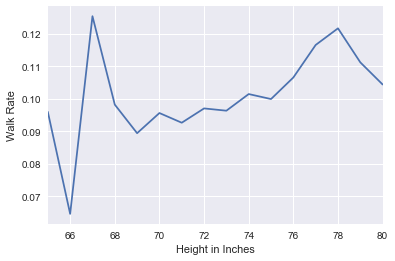

In [8]:
# Calculate walk rate without height of 82
total_bb_by_height = batting_filtered.groupby('height')['BB'].sum()
height_group_bb = total_bb_by_height / total_ab_by_height

# Retrieve walk value
bb_sample = batting_filtered['BB/AB']

# Print standard deviation between height and walk rate
print ("Standard deviation: " + str(height_group_bb.values.std(ddof=1)))

# Print Pearson's correlation coefficient for a sample
print("Pearson's R: " + str(pearson_r(height_sample,bb_sample)))

# Plot height vs walk rate
fig = height_group_bb.plot()
fig.set_xlabel('Height in Inches')
fig.set_ylabel('Walk Rate')

The analysis of the correlation of height and walk rate average shows shorter and taller players enjoy the higher walk rate. The Pearson's R value of 0.50 shows that in general taller players enjoy higher walk rates.

Standard deviation: 0.0147914717571
Pearson's R: 0.970988447397


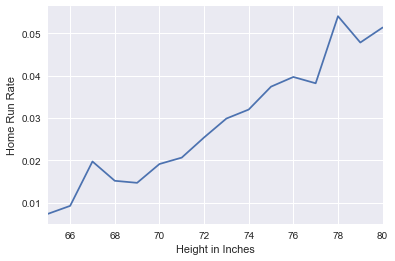

In [9]:
# Calculate home run rate without height of 82
total_hr_by_height = batting_filtered.groupby('height')['HR'].sum()
height_group_hr = total_hr_by_height / total_ab_by_height

# Retrieve home run value
hr_sample = batting_filtered['HR/AB']

# Print standard deviation between height and home run rate
print ("Standard deviation: " + str(height_group_hr.values.std(ddof=1)))

# Print Pearson's correlation coefficient for a sample
print("Pearson's R: " + str(pearson_r(height_sample,hr_sample)))

# Plot height vs home run rate
fig = height_group_hr.plot()
fig.set_xlabel('Height in Inches')
fig.set_ylabel('Home Run Rate')

The analysis of the correlation of height and home run rate shows taller players has higher home run rate. This is confirmed by the Pearson's R value of 0.97, showing strong correlation between height and home run rate.

## Conclusion

In analyzing correlation between height and batting average, strikeout rate, walk rate, and home run rate, there were two sets of results. The batting average and walk rate showed shorter and taller players enjoyed more success than players of average height. The strikeout rate and home run rate showed strong correlation between height. The taller players enjoyed more home runs while striking out more.

Although the batting average, strikeout rate, walk rate, and home run rate paint a significant portion of a batter's offensive output, there are also limitations in the data. The Lahman's Database only shows Major League player's statistics. Shorter players or taller players who are at a disadvantage might not make it to the Major Leagues and therefore not be included in this data. 

Going back to the two most productive batters today, we know Aaron Judge (79 inches) is significantly outperforming batting average by 7.57 standard deviations, while generally following the trend of having high strikeout rate, walk rate, and home run rate expected from a tall player. Jose Altuve (66 inches) generally follows expected output from a shorter player.

As top offensive producers of 2017, Aaron Judge and Jose Altuve represents an outlier in offensive production. Based on historical performance and statistical analysis, we can conclude that players with average height enjoy the most offensive production.